In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import os
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout,LSTM

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import datetime
from datetime import date, timedelta
e_date = datetime.datetime.strptime('2020-06-20', '%Y-%m-%d')
i_date = datetime.datetime.strptime('2020-04-01', '%Y-%m-%d')

data_path = 'D:/universidad/universidad 4/TFG/recursos para el desarrollo/datos procesados/OD'

In [2]:
delta = e_date - i_date

target_days = []
for i in range(delta.days + 1):
    day = i_date + timedelta(days=i)
    target_days.append(day)

In [3]:
def read_OD_fn(source_type):
    ods = {}
    for date in tqdm_notebook(target_days):
        od_date= pd.read_csv(os.path.join(data_path, 'date_{}_OD_{}.csv'.format(source_type,date.strftime('%Y-%m-%d'))), 
                            index_col=0)
        ods[date] = od_date
    return ods

In [4]:
ine_ods = read_OD_fn('INE')

  0%|          | 0/81 [00:00<?, ?it/s]

# Serializar los datos

In [5]:
lista = []

for date in tqdm_notebook(target_days):
    lista.append(ine_ods[date].loc['total','total'])
    
del ine_ods

  0%|          | 0/81 [00:00<?, ?it/s]

In [6]:
df = pd.DataFrame (lista, columns = ['Viajes'], index= target_days)

In [7]:
df.head()

,Viajes
2020-04-01,2213123
2020-04-02,2254121
2020-04-03,2520095
2020-04-04,1934554
2020-04-05,1593385


# Visualización de datos

In [8]:
print(df.index.min())
print(df.index.max())

2020-04-01 00:00:00
2020-06-20 00:00:00


In [9]:
print(len(df['2020']))

81


In [10]:
df.describe()

,Viajes
count,8.100000e+01
mean,3.438222e+06
std,1.174931e+06
min,1.535886e+06
25%,2.488436e+06
50%,3.396402e+06
75%,4.445190e+06
max,5.519725e+06


In [11]:
meses = df.resample('M').mean()
meses

,Viajes
2020-04-30,2.356878e+06
2020-05-31,3.590722e+06
2020-06-30,4.823862e+06


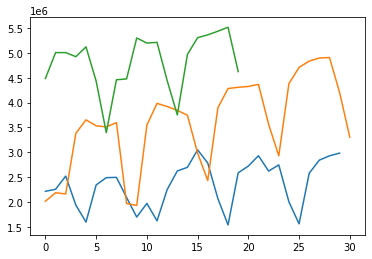

In [12]:
abril = df['2020-04-01':'2020-04-30']
plt.plot(abril.values)
mayo = df['2020-05-01':'2020-05-31']
plt.plot(mayo.values)
junio = df['2020-06-01':'2020-06-20']
plt.plot(junio.values)

# Preprocesado de datos

In [13]:
dataset = df.values
dataset = dataset.astype('float32')

In [14]:
# normalizamos el conjunto de datos
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# Dividimos los datos en sets de entrenamiento y validacion

In [15]:
#dividimos nuestros valores entre sets de entrenamiento y de test
n_train_days = 60
train = dataset[:n_train_days, :]
test = dataset[n_train_days:, :]

print(len(train), len(test))

60 21


In [16]:
# funcion para convertir un array de valores en una matriz de conjuntos de datos
def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  return np.array(dataX), np.array(dataY)

In [17]:
# dividimos en entradas y salidas
look_back = 7

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

print(len(trainX), len(testY))

53 14


In [18]:
print(trainX)

[[0.16999608 0.18028718 0.2470504  0.10007131 0.01443306 0.20226192
  0.23910356]
 [0.18028718 0.2470504  0.10007131 0.01443306 0.20226192 0.23910356
  0.24053836]
 [0.2470504  0.10007131 0.01443306 0.20226192 0.23910356 0.24053836
  0.1389401 ]
 [0.10007131 0.01443306 0.20226192 0.23910356 0.24053836 0.1389401
  0.03971621]
 [0.01443306 0.20226192 0.23910356 0.24053836 0.1389401  0.03971621
  0.10891479]
 [0.20226192 0.23910356 0.24053836 0.1389401  0.03971621 0.10891479
  0.02047423]
 [0.23910356 0.24053836 0.1389401  0.03971621 0.10891479 0.02047423
  0.17865783]
 [0.24053836 0.1389401  0.03971621 0.10891479 0.02047423 0.17865783
  0.27293295]
 [0.1389401  0.03971621 0.10891479 0.02047423 0.17865783 0.27293295
  0.2914425 ]
 [0.03971621 0.10891479 0.02047423 0.17865783 0.27293295 0.2914425
  0.37988257]
 [0.10891479 0.02047423 0.17865783 0.27293295 0.2914425  0.37988257
  0.313093  ]
 [0.02047423 0.17865783 0.27293295 0.2914425  0.37988257 0.313093
  0.13297123]
 [0.17865783 0.27293

In [19]:
# remodelamos la entrada para que sea[muestras, pasos de tiempo, características]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [20]:
print(trainX)

[[[0.16999608]
  [0.18028718]
  [0.2470504 ]
  [0.10007131]
  [0.01443306]
  [0.20226192]
  [0.23910356]]

 [[0.18028718]
  [0.2470504 ]
  [0.10007131]
  [0.01443306]
  [0.20226192]
  [0.23910356]
  [0.24053836]]

 [[0.2470504 ]
  [0.10007131]
  [0.01443306]
  [0.20226192]
  [0.23910356]
  [0.24053836]
  [0.1389401 ]]

 [[0.10007131]
  [0.01443306]
  [0.20226192]
  [0.23910356]
  [0.24053836]
  [0.1389401 ]
  [0.03971621]]

 [[0.01443306]
  [0.20226192]
  [0.23910356]
  [0.24053836]
  [0.1389401 ]
  [0.03971621]
  [0.10891479]]

 [[0.20226192]
  [0.23910356]
  [0.24053836]
  [0.1389401 ]
  [0.03971621]
  [0.10891479]
  [0.02047423]]

 [[0.23910356]
  [0.24053836]
  [0.1389401 ]
  [0.03971621]
  [0.10891479]
  [0.02047423]
  [0.17865783]]

 [[0.24053836]
  [0.1389401 ]
  [0.03971621]
  [0.10891479]
  [0.02047423]
  [0.17865783]
  [0.27293295]]

 [[0.1389401 ]
  [0.03971621]
  [0.10891479]
  [0.02047423]
  [0.17865783]
  [0.27293295]
  [0.2914425 ]]

 [[0.03971621]
  [0.10891479]
  [0.02

In [21]:
print(trainY)

[0.24053836 0.1389401  0.03971621 0.10891479 0.02047423 0.17865783
 0.27293295 0.2914425  0.37988257 0.313093   0.13297123 0.
 0.26343662 0.29775453 0.34997272 0.27233207 0.30363703 0.11689752
 0.00537395 0.26156402 0.32788748 0.3494845  0.36331165 0.11988008
 0.16276813 0.1565342  0.46347785 0.5314964  0.50147784 0.49586993
 0.51747626 0.10823756 0.09844148 0.5044481  0.61485875 0.59899086
 0.5796803  0.5546241  0.3633111  0.22455525 0.59261984 0.689921
 0.6962447  0.7003162  0.71110225 0.50901634 0.34968656 0.7144731
 0.7966052  0.82881963 0.8441757  0.8469062  0.6693162 ]


# Creamos la red neuronal

In [22]:
def crear_modeloFF():
    model = Sequential() 
    model.add(LSTM(20, input_shape=(look_back,1), return_sequences=True))
    model.add(LSTM(50, input_shape=(look_back,1), return_sequences=True))
    model.add(Dropout(0.30))
    model.add(LSTM(100, input_shape=(look_back,1)))
    model.add(Dropout(0.30))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.summary()
    return model

In [23]:
model = crear_modeloFF()

history=model.fit(trainX, trainY, epochs=200, validation_data=(testX,testY), batch_size=1, verbose=2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 20)             1760      
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 50)             14200     
_________________________________________________________________
dropout (Dropout)            (None, 7, 50)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 76,461
Trainable params: 76,461
Non-trainable params: 0
____________________________________________________

Epoch 123/200
53/53 - 0s - loss: 0.0148 - val_loss: 0.0083
Epoch 124/200
53/53 - 0s - loss: 0.0107 - val_loss: 0.0126
Epoch 125/200
53/53 - 0s - loss: 0.0124 - val_loss: 0.0121
Epoch 126/200
53/53 - 0s - loss: 0.0096 - val_loss: 0.0150
Epoch 127/200
53/53 - 0s - loss: 0.0113 - val_loss: 0.0092
Epoch 128/200
53/53 - 0s - loss: 0.0109 - val_loss: 0.0103
Epoch 129/200
53/53 - 0s - loss: 0.0115 - val_loss: 0.0255
Epoch 130/200
53/53 - 0s - loss: 0.0113 - val_loss: 0.0132
Epoch 131/200
53/53 - 0s - loss: 0.0113 - val_loss: 0.0181
Epoch 132/200
53/53 - 0s - loss: 0.0125 - val_loss: 0.0176
Epoch 133/200
53/53 - 0s - loss: 0.0140 - val_loss: 0.0091
Epoch 134/200
53/53 - 0s - loss: 0.0104 - val_loss: 0.0374
Epoch 135/200
53/53 - 0s - loss: 0.0106 - val_loss: 0.0124
Epoch 136/200
53/53 - 0s - loss: 0.0096 - val_loss: 0.0069
Epoch 137/200
53/53 - 0s - loss: 0.0093 - val_loss: 0.0137
Epoch 138/200
53/53 - 0s - loss: 0.0092 - val_loss: 0.0149
Epoch 139/200
53/53 - 0s - loss: 0.0096 - val_loss: 0.00

# Visualizamos resultados

In [24]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100


def compute_metrics_fn(y_valid_resc, y_hat_resc):
    mae_ = mean_absolute_error(y_valid_resc, y_hat_resc)
    mse_ = mean_squared_error(y_valid_resc, y_hat_resc)
    rmse_ = mean_squared_error(y_valid_resc, y_hat_resc, squared = False)
    cvrmse_ = rmse_/np.mean(y_valid_resc)*100
    mape_ = mape(y_valid_resc, y_hat_resc)
    
    return mae_, mse_, rmse_, cvrmse_, mape_

In [25]:
# hacemos las predicciones
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invertimos las predicciones
trainPredict = scaler.inverse_transform(trainPredict)
trainY_scalerInverse = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY_scalerInverse = scaler.inverse_transform([testY])

In [26]:
# calculamos las metricas de error
trainScore_MAE, trainScore_MSE, trainScore_RMSE, trainScore_CVRMSE, trainScore_MAPE  =  compute_metrics_fn(trainY_scalerInverse[0], trainPredict[:,0])
print('Resultado del entrenamiento: %.2f MAE' % (trainScore_MAE))
print('Resultado del entrenamiento: %.2f MSE' % (trainScore_MSE))
print('Resultado del entrenamiento: %.2f RMSE' % (trainScore_RMSE))
print('Resultado del entrenamiento: %.2f CVRMSE' % (trainScore_CVRMSE))
print('Resultado del entrenamiento: %.2f MAPE \n' % (trainScore_MAPE))

testScore_MAE, testScore_MSE, testScore_RMSE, testScore_CVRMSE, testScore_MAPE  =  compute_metrics_fn(testY_scalerInverse[0], testPredict[:,0])
print('Resultado del test: %.2f MAE' % (testScore_MAE))
print('Resultado del test: %.2f MSE' % (testScore_MSE))
print('Resultado del test: %.2f RMSE' % (testScore_RMSE))
print('Resultado del test: %.2f CVRMSE' % (testScore_CVRMSE))
print('Resultado del test: %.2f MAPE' % (testScore_MAPE))

Resultado del entrenamiento: 233028.68 MAE
Resultado del entrenamiento: 85748633575.84 MSE
Resultado del entrenamiento: 292828.68 RMSE
Resultado del entrenamiento: 9.50 CVRMSE
Resultado del entrenamiento: 9.05 MAPE 

Resultado del test: 360258.42 MAE
Resultado del test: 164740706411.05 MSE
Resultado del test: 405882.63 RMSE
Resultado del test: 8.42 CVRMSE
Resultado del test: 7.57 MAPE


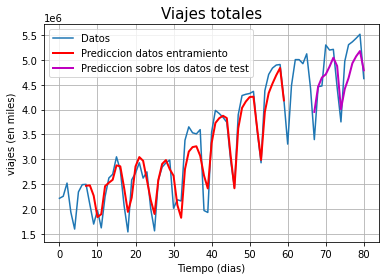

In [27]:
# predicciones del entrenamiento de cambio para plotear
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# predicciones del test de cambio para plotear
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2):len(dataset), :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
# ploteamos linea base y predicciones
plt.plot(trainPredictPlot,'r', linewidth = 2)
plt.plot(testPredictPlot,'m', linewidth = 2)
plt.legend( ('Datos', 'Prediccion datos entramiento', 'Prediccion sobre los datos de test'), loc = 'upper left')
plt.grid(True)
plt.title("Viajes totales", fontsize = 15)
plt.xlabel("Tiempo (dias)", fontsize = 10)
plt.ylabel("viajes (en miles)", fontsize = 10)
plt.show()

In [28]:
results=testPredict
print(len(results))

14


In [29]:
testResults = testY_scalerInverse[0]

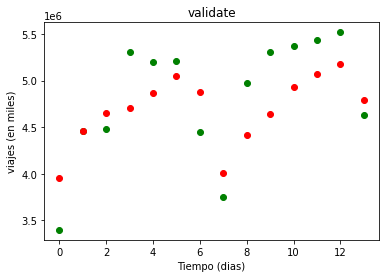

In [30]:
plt.scatter(range(len(testResults)),testResults,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('validate')
plt.xlabel("Tiempo (dias)", fontsize = 10)
plt.ylabel("viajes (en miles)", fontsize = 10)
plt.show()

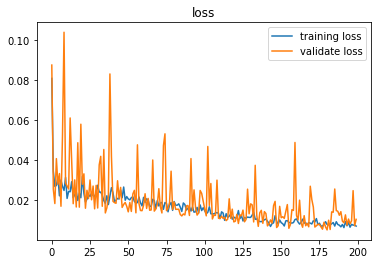

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.legend( ('training loss', 'validate loss'), loc = 'upper right')
plt.show()

In [32]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

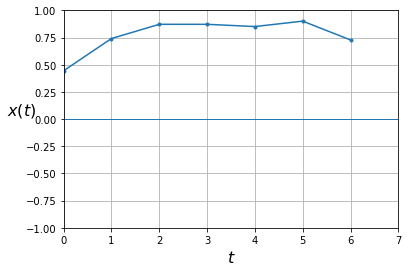

In [33]:
n_steps = 6 #preguntar
plot_series(testX[0, :, 0], testY_scalerInverse[0, 0], testPredict[0, 0])
plt.show()

# Exportar los datos

In [34]:
e_date = datetime.datetime.strptime('2020-06-20', '%Y-%m-%d')
i_date = datetime.datetime.strptime('2020-06-07', '%Y-%m-%d')
delta = e_date - i_date

index_days = []
for i in range(delta.days + 1):
    day = i_date + timedelta(days=i)
    index_days.append(day)

prediccion = pd.DataFrame(testPredict, index= index_days)
prediccion.columns = ['valor predicho']

prediccion

,valor predicho
2020-06-07,3954481.25
2020-06-08,4463572.00
2020-06-09,4648372.50
2020-06-10,4710369.50
2020-06-11,4867456.50
2020-06-12,5046471.50
2020-06-13,4879264.50
2020-06-14,4009021.50
2020-06-15,4417117.00
2020-06-16,4637675.50


In [35]:
datosReales = df['2020-6-07':'2020-6-20']

compara = pd.concat([datosReales, prediccion], axis=1)
compara.columns = ['real', 'prediccion']

compara

,real,prediccion
2020-06-07,3396402,3954481.25
2020-06-08,4461143,4463572.00
2020-06-09,4478072,4648372.50
2020-06-10,5303428,4710369.50
2020-06-11,5200931,4867456.50
2020-06-12,5215302,5046471.50
2020-06-13,4445190,4879264.50
2020-06-14,3753016,4009021.50
2020-06-15,4973188,4417117.00
2020-06-16,5308885,4637675.50


In [36]:
compara.to_excel('Resultados INE.xlsx', columns=['real', 'prediccion'])

# Prediccion a futuro

In [37]:
# usaremos 7 dias que poseemos para predecir los 7 dias siguientes tras esto compararemos los resultados con los que
# poseemos para ver el grado de error

Dias = df['2020-5-18':'2020-5-24']

In [38]:
# funcion para convertir un array de valores en una matriz de conjuntos de datos, en este caso modificada para ayudarnos a crear
#los distintos sets de entrenmiento para distintos modelos que predeciran 1 dia cada uno

def create_dataset2(dataset, look_back=1, dias=0):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-dias):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back + dias, 0])
  return np.array(dataX), np.array(dataY)

In [39]:
#ahora crearemos los sets para entrenar los modelos
look_back = 7

trainX1, trainY1 = create_dataset2(train, look_back, 1)
testX1, testY1 = create_dataset2(test, look_back, 1)

trainX2, trainY2 = create_dataset2(train, look_back, 2)
testX2, testY2 = create_dataset2(test, look_back, 2)

trainX3, trainY3 = create_dataset2(train, look_back, 3)
testX3, testY3 = create_dataset2(test, look_back, 3)

trainX4, trainY4 = create_dataset2(train, look_back, 4)
testX4, testY4 = create_dataset2(test, look_back, 4)

trainX5, trainY5 = create_dataset2(train, look_back, 5)
testX5, testY5 = create_dataset2(test, look_back, 5)

trainX6, trainY6 = create_dataset2(train, look_back, 6)
testX6, testY6 = create_dataset2(test, look_back, 6)

In [40]:
print(trainX1)

[[0.16999608 0.18028718 0.2470504  0.10007131 0.01443306 0.20226192
  0.23910356]
 [0.18028718 0.2470504  0.10007131 0.01443306 0.20226192 0.23910356
  0.24053836]
 [0.2470504  0.10007131 0.01443306 0.20226192 0.23910356 0.24053836
  0.1389401 ]
 [0.10007131 0.01443306 0.20226192 0.23910356 0.24053836 0.1389401
  0.03971621]
 [0.01443306 0.20226192 0.23910356 0.24053836 0.1389401  0.03971621
  0.10891479]
 [0.20226192 0.23910356 0.24053836 0.1389401  0.03971621 0.10891479
  0.02047423]
 [0.23910356 0.24053836 0.1389401  0.03971621 0.10891479 0.02047423
  0.17865783]
 [0.24053836 0.1389401  0.03971621 0.10891479 0.02047423 0.17865783
  0.27293295]
 [0.1389401  0.03971621 0.10891479 0.02047423 0.17865783 0.27293295
  0.2914425 ]
 [0.03971621 0.10891479 0.02047423 0.17865783 0.27293295 0.2914425
  0.37988257]
 [0.10891479 0.02047423 0.17865783 0.27293295 0.2914425  0.37988257
  0.313093  ]
 [0.02047423 0.17865783 0.27293295 0.2914425  0.37988257 0.313093
  0.13297123]
 [0.17865783 0.27293

In [41]:
print(trainY1)

[0.1389401  0.03971621 0.10891479 0.02047423 0.17865783 0.27293295
 0.2914425  0.37988257 0.313093   0.13297123 0.         0.26343662
 0.29775453 0.34997272 0.27233207 0.30363703 0.11689752 0.00537395
 0.26156402 0.32788748 0.3494845  0.36331165 0.11988008 0.16276813
 0.1565342  0.46347785 0.5314964  0.50147784 0.49586993 0.51747626
 0.10823756 0.09844148 0.5044481  0.61485875 0.59899086 0.5796803
 0.5546241  0.3633111  0.22455525 0.59261984 0.689921   0.6962447
 0.7003162  0.71110225 0.50901634 0.34968656 0.7144731  0.7966052
 0.82881963 0.8441757  0.8469062  0.6693162 ]


In [42]:
# remodelamos la entrada para que sea[muestras, pasos de tiempo, características]

trainX1 = np.reshape(trainX1, (trainX1.shape[0], trainX1.shape[1], 1))
testX1 = np.reshape(testX1, (testX1.shape[0], testX1.shape[1], 1))

trainX2 = np.reshape(trainX2, (trainX2.shape[0], trainX2.shape[1], 1))
testX2 = np.reshape(testX2, (testX2.shape[0], testX2.shape[1], 1))

trainX3 = np.reshape(trainX3, (trainX3.shape[0], trainX3.shape[1], 1))
testX3 = np.reshape(testX3, (testX3.shape[0], testX3.shape[1], 1))

trainX4 = np.reshape(trainX4, (trainX4.shape[0], trainX4.shape[1], 1))
testX4 = np.reshape(testX4, (testX4.shape[0], testX4.shape[1], 1))

trainX5 = np.reshape(trainX5, (trainX5.shape[0], trainX5.shape[1], 1))
testX5 = np.reshape(testX5, (testX5.shape[0], testX5.shape[1], 1))

trainX6 = np.reshape(trainX6, (trainX6.shape[0], trainX6.shape[1], 1))
testX6 = np.reshape(testX6, (testX6.shape[0], testX6.shape[1], 1))

In [43]:
#creamos los distintos modelos para predecir cada dia

model1 = crear_modeloFF()
history=model1.fit(trainX1, trainY1, epochs=200, validation_data=(testX1,testY1), batch_size=1, verbose=2)

model2 = crear_modeloFF()
history=model2.fit(trainX2, trainY2, epochs=200, validation_data=(testX2,testY2), batch_size=1, verbose=2)

model3 = crear_modeloFF()
history=model3.fit(trainX3, trainY3, epochs=200, validation_data=(testX3,testY3), batch_size=1, verbose=2)

model4 = crear_modeloFF()
history=model4.fit(trainX4, trainY4, epochs=200, validation_data=(testX4,testY4), batch_size=1, verbose=2)

model5 = crear_modeloFF()
history=model5.fit(trainX5, trainY5, epochs=200, validation_data=(testX5,testY5), batch_size=1, verbose=2)

model6 = crear_modeloFF()
history=model6.fit(trainX6, trainY6, epochs=200, validation_data=(testX6,testY6), batch_size=1, verbose=2)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 7, 20)             1760      
_________________________________________________________________
lstm_4 (LSTM)                (None, 7, 50)             14200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 50)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 76,461
Trainable params: 76,461
Non-trainable params: 0
__________________________________________________

52/52 - 0s - loss: 0.0110 - val_loss: 0.0111
Epoch 123/200
52/52 - 0s - loss: 0.0139 - val_loss: 0.0099
Epoch 124/200
52/52 - 0s - loss: 0.0129 - val_loss: 0.0099
Epoch 125/200
52/52 - 0s - loss: 0.0112 - val_loss: 0.0223
Epoch 126/200
52/52 - 0s - loss: 0.0123 - val_loss: 0.0090
Epoch 127/200
52/52 - 0s - loss: 0.0129 - val_loss: 0.0150
Epoch 128/200
52/52 - 0s - loss: 0.0107 - val_loss: 0.0107
Epoch 129/200
52/52 - 0s - loss: 0.0122 - val_loss: 0.0156
Epoch 130/200
52/52 - 0s - loss: 0.0146 - val_loss: 0.0097
Epoch 131/200
52/52 - 0s - loss: 0.0118 - val_loss: 0.0112
Epoch 132/200
52/52 - 0s - loss: 0.0112 - val_loss: 0.0127
Epoch 133/200
52/52 - 0s - loss: 0.0143 - val_loss: 0.0125
Epoch 134/200
52/52 - 0s - loss: 0.0113 - val_loss: 0.0100
Epoch 135/200
52/52 - 0s - loss: 0.0124 - val_loss: 0.0087
Epoch 136/200
52/52 - 0s - loss: 0.0130 - val_loss: 0.0108
Epoch 137/200
52/52 - 0s - loss: 0.0118 - val_loss: 0.0094
Epoch 138/200
52/52 - 0s - loss: 0.0139 - val_loss: 0.0107
Epoch 139/2

Epoch 43/200
51/51 - 0s - loss: 0.0147 - val_loss: 0.0220
Epoch 44/200
51/51 - 0s - loss: 0.0167 - val_loss: 0.0079
Epoch 45/200
51/51 - 0s - loss: 0.0190 - val_loss: 0.0089
Epoch 46/200
51/51 - 0s - loss: 0.0179 - val_loss: 0.0103
Epoch 47/200
51/51 - 0s - loss: 0.0135 - val_loss: 0.0089
Epoch 48/200
51/51 - 0s - loss: 0.0148 - val_loss: 0.0230
Epoch 49/200
51/51 - 0s - loss: 0.0144 - val_loss: 0.0138
Epoch 50/200
51/51 - 0s - loss: 0.0146 - val_loss: 0.0098
Epoch 51/200
51/51 - 0s - loss: 0.0132 - val_loss: 0.0616
Epoch 52/200
51/51 - 0s - loss: 0.0156 - val_loss: 0.0203
Epoch 53/200
51/51 - 0s - loss: 0.0140 - val_loss: 0.0396
Epoch 54/200
51/51 - 0s - loss: 0.0131 - val_loss: 0.0158
Epoch 55/200
51/51 - 0s - loss: 0.0095 - val_loss: 0.0124
Epoch 56/200
51/51 - 0s - loss: 0.0128 - val_loss: 0.0116
Epoch 57/200
51/51 - 0s - loss: 0.0144 - val_loss: 0.0084
Epoch 58/200
51/51 - 0s - loss: 0.0146 - val_loss: 0.0084
Epoch 59/200
51/51 - 0s - loss: 0.0132 - val_loss: 0.0086
Epoch 60/200
5

Epoch 183/200
51/51 - 0s - loss: 0.0101 - val_loss: 0.0100
Epoch 184/200
51/51 - 0s - loss: 0.0131 - val_loss: 0.0408
Epoch 185/200
51/51 - 0s - loss: 0.0125 - val_loss: 0.0094
Epoch 186/200
51/51 - 0s - loss: 0.0106 - val_loss: 0.0096
Epoch 187/200
51/51 - 0s - loss: 0.0105 - val_loss: 0.0219
Epoch 188/200
51/51 - 0s - loss: 0.0121 - val_loss: 0.0097
Epoch 189/200
51/51 - 0s - loss: 0.0121 - val_loss: 0.0132
Epoch 190/200
51/51 - 0s - loss: 0.0125 - val_loss: 0.0118
Epoch 191/200
51/51 - 0s - loss: 0.0104 - val_loss: 0.0097
Epoch 192/200
51/51 - 0s - loss: 0.0107 - val_loss: 0.0121
Epoch 193/200
51/51 - 0s - loss: 0.0094 - val_loss: 0.0148
Epoch 194/200
51/51 - 0s - loss: 0.0100 - val_loss: 0.0112
Epoch 195/200
51/51 - 0s - loss: 0.0111 - val_loss: 0.0138
Epoch 196/200
51/51 - 0s - loss: 0.0087 - val_loss: 0.0097
Epoch 197/200
51/51 - 0s - loss: 0.0094 - val_loss: 0.0099
Epoch 198/200
51/51 - 0s - loss: 0.0103 - val_loss: 0.0104
Epoch 199/200
51/51 - 0s - loss: 0.0130 - val_loss: 0.00

50/50 - 0s - loss: 0.0107 - val_loss: 0.0124
Epoch 105/200
50/50 - 0s - loss: 0.0117 - val_loss: 0.0112
Epoch 106/200
50/50 - 0s - loss: 0.0102 - val_loss: 0.0093
Epoch 107/200
50/50 - 0s - loss: 0.0099 - val_loss: 0.0102
Epoch 108/200
50/50 - 0s - loss: 0.0121 - val_loss: 0.0117
Epoch 109/200
50/50 - 0s - loss: 0.0105 - val_loss: 0.0121
Epoch 110/200
50/50 - 0s - loss: 0.0094 - val_loss: 0.0118
Epoch 111/200
50/50 - 0s - loss: 0.0118 - val_loss: 0.0207
Epoch 112/200
50/50 - 0s - loss: 0.0099 - val_loss: 0.0123
Epoch 113/200
50/50 - 0s - loss: 0.0103 - val_loss: 0.0146
Epoch 114/200
50/50 - 0s - loss: 0.0100 - val_loss: 0.0113
Epoch 115/200
50/50 - 0s - loss: 0.0105 - val_loss: 0.0120
Epoch 116/200
50/50 - 0s - loss: 0.0104 - val_loss: 0.0135
Epoch 117/200
50/50 - 0s - loss: 0.0104 - val_loss: 0.0104
Epoch 118/200
50/50 - 0s - loss: 0.0103 - val_loss: 0.0102
Epoch 119/200
50/50 - 0s - loss: 0.0101 - val_loss: 0.0164
Epoch 120/200
50/50 - 0s - loss: 0.0090 - val_loss: 0.0130
Epoch 121/2

49/49 - 0s - loss: 0.0167 - val_loss: 0.0146
Epoch 25/200
49/49 - 0s - loss: 0.0150 - val_loss: 0.0594
Epoch 26/200
49/49 - 0s - loss: 0.0153 - val_loss: 0.0097
Epoch 27/200
49/49 - 0s - loss: 0.0162 - val_loss: 0.0094
Epoch 28/200
49/49 - 0s - loss: 0.0175 - val_loss: 0.0130
Epoch 29/200
49/49 - 0s - loss: 0.0155 - val_loss: 0.2353
Epoch 30/200
49/49 - 0s - loss: 0.0301 - val_loss: 0.0076
Epoch 31/200
49/49 - 0s - loss: 0.0191 - val_loss: 0.0412
Epoch 32/200
49/49 - 0s - loss: 0.0140 - val_loss: 0.0113
Epoch 33/200
49/49 - 0s - loss: 0.0165 - val_loss: 0.0457
Epoch 34/200
49/49 - 0s - loss: 0.0166 - val_loss: 0.0214
Epoch 35/200
49/49 - 0s - loss: 0.0149 - val_loss: 0.0251
Epoch 36/200
49/49 - 0s - loss: 0.0178 - val_loss: 0.0078
Epoch 37/200
49/49 - 0s - loss: 0.0176 - val_loss: 0.0116
Epoch 38/200
49/49 - 0s - loss: 0.0188 - val_loss: 0.0154
Epoch 39/200
49/49 - 0s - loss: 0.0143 - val_loss: 0.0126
Epoch 40/200
49/49 - 0s - loss: 0.0171 - val_loss: 0.0120
Epoch 41/200
49/49 - 0s - l

Epoch 165/200
49/49 - 0s - loss: 0.0116 - val_loss: 0.0128
Epoch 166/200
49/49 - 0s - loss: 0.0103 - val_loss: 0.0140
Epoch 167/200
49/49 - 0s - loss: 0.0099 - val_loss: 0.0036
Epoch 168/200
49/49 - 0s - loss: 0.0090 - val_loss: 0.0105
Epoch 169/200
49/49 - 0s - loss: 0.0108 - val_loss: 0.0039
Epoch 170/200
49/49 - 0s - loss: 0.0120 - val_loss: 0.0028
Epoch 171/200
49/49 - 0s - loss: 0.0086 - val_loss: 0.0081
Epoch 172/200
49/49 - 0s - loss: 0.0111 - val_loss: 0.0099
Epoch 173/200
49/49 - 0s - loss: 0.0125 - val_loss: 0.0031
Epoch 174/200
49/49 - 0s - loss: 0.0113 - val_loss: 0.0020
Epoch 175/200
49/49 - 0s - loss: 0.0096 - val_loss: 0.0034
Epoch 176/200
49/49 - 0s - loss: 0.0104 - val_loss: 0.0064
Epoch 177/200
49/49 - 0s - loss: 0.0111 - val_loss: 0.0056
Epoch 178/200
49/49 - 0s - loss: 0.0107 - val_loss: 0.0058
Epoch 179/200
49/49 - 0s - loss: 0.0091 - val_loss: 0.0231
Epoch 180/200
49/49 - 0s - loss: 0.0115 - val_loss: 0.0062
Epoch 181/200
49/49 - 0s - loss: 0.0102 - val_loss: 0.01

Epoch 86/200
48/48 - 0s - loss: 0.0122 - val_loss: 0.0111
Epoch 87/200
48/48 - 0s - loss: 0.0145 - val_loss: 0.0076
Epoch 88/200
48/48 - 0s - loss: 0.0124 - val_loss: 0.0192
Epoch 89/200
48/48 - 0s - loss: 0.0104 - val_loss: 0.0108
Epoch 90/200
48/48 - 0s - loss: 0.0097 - val_loss: 0.0160
Epoch 91/200
48/48 - 0s - loss: 0.0118 - val_loss: 0.0290
Epoch 92/200
48/48 - 0s - loss: 0.0125 - val_loss: 0.0447
Epoch 93/200
48/48 - 0s - loss: 0.0114 - val_loss: 0.0144
Epoch 94/200
48/48 - 0s - loss: 0.0112 - val_loss: 0.0173
Epoch 95/200
48/48 - 0s - loss: 0.0102 - val_loss: 0.0411
Epoch 96/200
48/48 - 0s - loss: 0.0107 - val_loss: 0.0118
Epoch 97/200
48/48 - 0s - loss: 0.0107 - val_loss: 0.0477
Epoch 98/200
48/48 - 0s - loss: 0.0119 - val_loss: 0.0363
Epoch 99/200
48/48 - 0s - loss: 0.0131 - val_loss: 0.0271
Epoch 100/200
48/48 - 0s - loss: 0.0107 - val_loss: 0.0061
Epoch 101/200
48/48 - 0s - loss: 0.0116 - val_loss: 0.0508
Epoch 102/200
48/48 - 0s - loss: 0.0137 - val_loss: 0.0409
Epoch 103/2

Epoch 6/200
47/47 - 0s - loss: 0.0557 - val_loss: 0.0306
Epoch 7/200
47/47 - 0s - loss: 0.0363 - val_loss: 0.0272
Epoch 8/200
47/47 - 0s - loss: 0.0405 - val_loss: 0.0547
Epoch 9/200
47/47 - 0s - loss: 0.0400 - val_loss: 0.0270
Epoch 10/200
47/47 - 0s - loss: 0.0350 - val_loss: 0.1292
Epoch 11/200
47/47 - 0s - loss: 0.0464 - val_loss: 0.0706
Epoch 12/200
47/47 - 0s - loss: 0.0380 - val_loss: 0.0591
Epoch 13/200
47/47 - 0s - loss: 0.0317 - val_loss: 0.0277
Epoch 14/200
47/47 - 0s - loss: 0.0376 - val_loss: 0.0281
Epoch 15/200
47/47 - 0s - loss: 0.0386 - val_loss: 0.0267
Epoch 16/200
47/47 - 0s - loss: 0.0363 - val_loss: 0.0297
Epoch 17/200
47/47 - 0s - loss: 0.0322 - val_loss: 0.0320
Epoch 18/200
47/47 - 0s - loss: 0.0380 - val_loss: 0.0255
Epoch 19/200
47/47 - 0s - loss: 0.0324 - val_loss: 0.0322
Epoch 20/200
47/47 - 0s - loss: 0.0354 - val_loss: 0.0303
Epoch 21/200
47/47 - 0s - loss: 0.0307 - val_loss: 0.0807
Epoch 22/200
47/47 - 0s - loss: 0.0337 - val_loss: 0.0271
Epoch 23/200
47/47

Epoch 147/200
47/47 - 0s - loss: 0.0105 - val_loss: 0.0204
Epoch 148/200
47/47 - 0s - loss: 0.0086 - val_loss: 0.0311
Epoch 149/200
47/47 - 0s - loss: 0.0112 - val_loss: 0.0087
Epoch 150/200
47/47 - 0s - loss: 0.0095 - val_loss: 0.0192
Epoch 151/200
47/47 - 0s - loss: 0.0084 - val_loss: 0.0112
Epoch 152/200
47/47 - 0s - loss: 0.0090 - val_loss: 0.0272
Epoch 153/200
47/47 - 0s - loss: 0.0082 - val_loss: 0.0072
Epoch 154/200
47/47 - 0s - loss: 0.0087 - val_loss: 0.0112
Epoch 155/200
47/47 - 0s - loss: 0.0093 - val_loss: 0.0062
Epoch 156/200
47/47 - 0s - loss: 0.0086 - val_loss: 0.0067
Epoch 157/200
47/47 - 0s - loss: 0.0098 - val_loss: 0.0142
Epoch 158/200
47/47 - 0s - loss: 0.0086 - val_loss: 0.0076
Epoch 159/200
47/47 - 0s - loss: 0.0075 - val_loss: 0.0188
Epoch 160/200
47/47 - 0s - loss: 0.0102 - val_loss: 0.0095
Epoch 161/200
47/47 - 0s - loss: 0.0085 - val_loss: 0.0076
Epoch 162/200
47/47 - 0s - loss: 0.0084 - val_loss: 0.0217
Epoch 163/200
47/47 - 0s - loss: 0.0101 - val_loss: 0.01

# Preparamos los datos para el test

In [44]:
# cargamos el dataframe en la variable dataset
dataset = Dias.values

# convertimos los enteros en floats
dataset = dataset.astype('float32')

# normalizamos los datos
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [45]:
#remodelamos los datos
testX = np.reshape(dataset, (1, 7, 1))

# Predicciones para la proxima semana

In [46]:
results = []

parcial=model.predict(testX)
results.append(parcial[0])

parcial=model1.predict(testX)
results.append(parcial[0])

parcial=model2.predict(testX)
results.append(parcial[0])

parcial=model3.predict(testX)
results.append(parcial[0])

parcial=model4.predict(testX)
results.append(parcial[0])

parcial=model5.predict(testX)
results.append(parcial[0])

parcial=model6.predict(testX)
results.append(parcial[0])

results = np.reshape(results, (7, 1))
print(results)

[[0.64307225]
 [0.8216734 ]
 [1.0165092 ]
 [0.9314252 ]
 [1.053134  ]
 [0.94340956]
 [0.43110973]]


# Re-Convertimos los resultados

In [47]:
inverted = scaler.inverse_transform(results)

#en nuestro problema no tienen sentido los decimales pues no se pueden hacer 0.5 viajes o 0.25 viajes
inverted = inverted.round()
inverted = inverted.astype(int)

inverted

array([[3854890],
       [4112044],
       [4392573],
       [4270068],
       [4445306],
       [4287322],
       [3549702]])

# Visualizamos el pronostico

<AxesSubplot:>

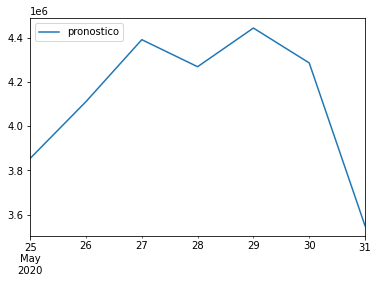

In [48]:
e_date = datetime.datetime.strptime('2020-05-31', '%Y-%m-%d')
i_date = datetime.datetime.strptime('2020-05-25', '%Y-%m-%d')
delta = e_date - i_date

index_days = []
for i in range(delta.days + 1):
    day = i_date + timedelta(days=i)
    index_days.append(day)

prediccion = pd.DataFrame(inverted, index= index_days)
prediccion.columns = ['pronostico']
prediccion.plot()

In [49]:
datosReales = df['2020-5-25':'2020-5-31']

compara = pd.concat([datosReales, prediccion], axis=1)
compara.columns = ['real', 'prediccion']

compara

,real,prediccion
2020-05-25,4382232,3854890
2020-05-26,4709433,4112044
2020-05-27,4837770,4392573
2020-05-28,4898946,4270068
2020-05-29,4909824,4445306
2020-05-30,4202334,4287322
2020-05-31,3305717,3549702


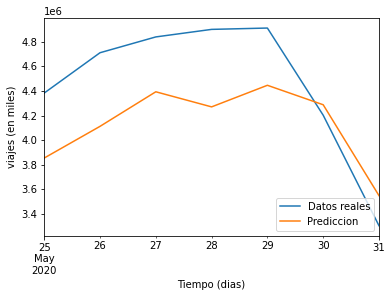

In [50]:
compara['real'].plot()
compara['prediccion'].plot()
plt.xlabel("Tiempo (dias)", fontsize = 10)
plt.ylabel("viajes (en miles)", fontsize = 10)
plt.legend( ('Datos reales', 'Prediccion'), loc = 'lower right')

In [51]:
# calculamos las metricas de error
testScore_MAE, testScore_MSE, testScore_RMSE, testScore_CVRMSE, testScore_MAPE  =  compute_metrics_fn(prediccion, datosReales)
print('Resultado del test: %.2f MAE' % (testScore_MAE))
print('Resultado del test: %.2f MSE' % (testScore_MSE))
print('Resultado del test: %.2f RMSE' % (testScore_RMSE))
print('Resultado del test: %.2f CVRMSE' % (testScore_CVRMSE))
print('Resultado del test: %.2f MAPE' % (testScore_MAPE))

Resultado del test: 427471.00 MAE
Resultado del test: 215882817524.43 MSE
Resultado del test: 464631.92 RMSE
Resultado del test: 11.25 CVRMSE
Resultado del test: 10.34 MAPE
